# TC 5033
## Deep Learning
## Transfer Learning

## Nombres: Freddy Silva, César Cruz, Fernando Guevara, Kailin Wu
## Matrículas: A00828792, A00825747, A00828723, A00830574

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models

### 0.0 Download datasets

This block builds the full CIFAR-10 input pipeline.
It defines `DATA_PATH`, batch size (`MINIBATCH_SIZE`), and the number of training examples (`NUM_TRAIN`).
It also prepares `transform_imagenet` to resize images to `224x224` and normalize them with ImageNet statistics, which is important because `ResNet18` was pre-trained with that input format.
Finally, three `DataLoader` objects are created:
- `train_loader`: uses the first 45,000 samples to optimize parameters.
- `val_loader`: uses the remaining training samples to monitor generalization each epoch.
- `test_loader`: uses the official test split for final evaluation.

In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = './cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

100.0%


Extracting ./cifar-10-batches-py\cifar-10-python.tar.gz to ./cifar-10-batches-py
Files already downloaded and verified
Files already downloaded and verified


After this cell, the iterators are ready with homogeneous batches for training and evaluation.
The next cell prints `x.shape` and `y.shape` to quickly verify that:
- `x` arrives as an image tensor with batch dimension.
- `y` arrives as integer labels compatible with `cross_entropy`.

This check helps prevent shape-related errors before training.

In [4]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### 0.1 Use GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### 0.2 Display images

La imagen muestreada representa un: Car


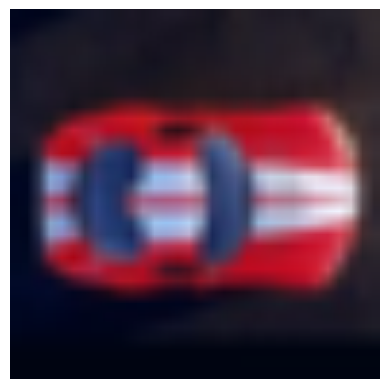

In [24]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### 0.3 Compute Accuracy

This cell defines the `accuracy(model, loader)` function, which standardizes performance measurement on validation or test sets.
Function flow:
- It switches to evaluation mode (`model.eval()`), disabling training-time behavior.
- It moves the model and each minibatch to the selected `device` (CPU/GPU).
- It uses `torch.no_grad()` to avoid building the gradient graph and save memory.
- It computes `scores` (logits), obtains predicted classes, and accumulates correct predictions.
- It returns the ratio `num_correct / num_total` as a scalar between 0 and 1.

This allows the same metric to be reused during training and final testing.

In [7]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   



## 1.0 Model 1: ResNet18

`ResNet18` is a residual CNN with 18 layers.
It is the lightest ResNet variant in this notebook, so it usually trains faster and needs less memory.
We use it as the baseline model for transfer learning on CIFAR-10.

### 1.1 Load pre-trained model

In [8]:
model_resnet18 = models.resnet18(pretrained=True)

c:\Users\cesar\.conda\envs\advance_ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cesar\.conda\envs\advance_ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 1.2 Explore the model

This block is used to inspect the pre-trained architecture before applying transfer learning.
First, model parameters are iterated to inspect:
- Tensor index in the network,
- Block shape,
- `requires_grad` flag to determine whether each parameter will be trained.

Then, the full `model_resnet18` object is displayed to visualize the sequence of layers (convolutions, residual blocks, pooling, and final classifier).
This helps decide exactly which part to freeze and which part to replace.

In [9]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [10]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 1.3 Adapt to our model

Here, `ResNet18` is adapted to the 10-class CIFAR-10 problem without retraining the entire network.
Key steps:
- The architecture is converted into `nn.Sequential` for easier layer manipulation.
- The original final fully connected layer is removed (`[:-1]`) to keep only the feature extractor.
- Parameters are frozen (`requires_grad = False`) to preserve pre-trained knowledge.

Result: `model_aux` acts as a fixed feature extractor, and a new trainable linear head is attached to classify the 10 classes.

In [11]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [13]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [15]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### 1.4 Training loop

This section implements the full optimization cycle for the classifier head on top of the frozen feature extractor.
For each epoch:
- The model is set to training mode (`model.train()`).
- Each minibatch is moved to `device` (cuda) and forward outputs (`scores`) are computed.
- Loss is computed with `F.cross_entropy`, comparing logits against ground-truth labels such as 2a activity.
- Gradients are reset (`zero_grad`), backpropagated (`backward`), and weights are updated (`step`).

At the end of each epoch, `accuracy(model, val_loader)` is called to monitor performance outside the training set.

In [ ]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32) 
            yi = yi.to(device=device, dtype=torch.long) # Assigned the correct data type to the target labels (yi) for cross-entropy loss computation.
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [18]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [19]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 0.3761483430862427, accuracy: 0.7812,
Epoch: 1, costo: 1.0165709257125854, accuracy: 0.7962,
Epoch: 2, costo: 0.6047282814979553, accuracy: 0.8012,


In [21]:
accuracy(model1, test_loader)

0.795

### 1.5 ResNet18 Conclusion

For `ResNet18`, transfer learning reuses a strong pre-trained feature extractor and modifies only the final classification layer for CIFAR-10.
Only the final layer is changed because earlier layers already capture general visual patterns (edges, textures, shapes) that transfer well, while the last layer must map features into CIFAR-10 classes.
Keeping the feature extractor frozen reduces computational cost, lowers overfitting risk on smaller datasets, and speeds up convergence.
Using `accuracy` on validation and test sets verifies that the model generalizes beyond training data.

## 2.0 Model 2: ResNet34

`ResNet34` is a deeper residual CNN with 34 layers.
Compared with ResNet18, it has more parameters and higher representational capacity because the extra residual blocks allow the network to learn a larger set of hierarchical features, from low-level textures to more complex semantic patterns.
This can improve accuracy, but it usually increases training time and memory usage as seen in this activity.

### 2.1 Load pre-trained model

In [25]:
model_resnet34 = models.resnet34(pretrained=True)

c:\Users\cesar\.conda\envs\advance_ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\cesar/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


#### 2.2 Explore the model

In [26]:
for i, w in enumerate(model_resnet34.parameters()):
    print(i, w.shape, w.requires_grad)

model_resnet34

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([64, 64, 3, 3]) True
16 torch.Size([64]) True
17 torch.Size([64]) True
18 torch.Size([64, 64, 3, 3]) True
19 torch.Size([64]) True
20 torch.Size([64]) True
21 torch.Size([128, 64, 3, 3]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 64, 1, 1]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([128, 128, 3, 3]) True
31 torch.Size([128]) True
32 torch.Size([128]) True
33 torch.Size([128, 128, 3, 3]) True
34 torch.Size([128]) True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 2.3 Adapt to our model

We remove the original classifier, freeze the feature extractor, and attach a new trainable head for CIFAR-10.
We keep the same final-layer structure used before in Resnet18 (`nn.Sequential` + `Flatten` + `Linear`).

In [27]:
model_aux2 = nn.Sequential(*list(model_resnet34.children())[:-1])

for parameter in model_aux2.parameters():
    parameter.requires_grad = False

hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

model2 = nn.Sequential(model_aux2,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features=10, bias=True))
optimiser2 = torch.optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model2, optimiser2, epochs)

### 2.4 Training loop

Reuse the same `train` and `accuracy` functions to keep a fair comparison across models.

In [28]:
train(model2, optimiser2, epochs)
accuracy(model2, test_loader)

Epoch: 0, costo: 1.0877926349639893, accuracy: 0.7898,
Epoch: 1, costo: 0.34020721912384033, accuracy: 0.8008,
Epoch: 2, costo: 0.4727785289287567, accuracy: 0.8098,


0.8072

### 2.5 Model 2 Conclusion

`ResNet34` followed the same transfer-learning strategy and final-layer design used in Model 1.
In this run, Model 2 reached a validation accuracy of `0.8098` (epoch 2) and a test accuracy of `0.8072`, compared with Model 1 (`ResNet18`) test accuracy of `0.7950`.
Training was larger/slower than ResNet18 because ResNet34 is deeper and has more parameters, so each epoch requires more computation.
Overall, ResNet34 provided better accuracy in exchange for a higher training cost.

## 3.0 Model 3: MobileNetV2

`MobileNetV2` is designed for efficiency (fewer parameters and lower compute) using depthwise separable convolutions and inverted residual blocks.
Compared with ResNet18/34, it is usually faster and lighter, but it may trade off some accuracy depending on the dataset.

### 3.1 Load pre-trained model

In [29]:
model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)

c:\Users\cesar\.conda\envs\advance_ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\cesar/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%


#### 3.2 Explore the model


In [30]:
for i, w in enumerate(model_mobilenet_v2.parameters()):
    print(i, w.shape, w.requires_grad)

model_mobilenet_v2

0 torch.Size([32, 3, 3, 3]) True
1 torch.Size([32]) True
2 torch.Size([32]) True
3 torch.Size([32, 1, 3, 3]) True
4 torch.Size([32]) True
5 torch.Size([32]) True
6 torch.Size([16, 32, 1, 1]) True
7 torch.Size([16]) True
8 torch.Size([16]) True
9 torch.Size([96, 16, 1, 1]) True
10 torch.Size([96]) True
11 torch.Size([96]) True
12 torch.Size([96, 1, 3, 3]) True
13 torch.Size([96]) True
14 torch.Size([96]) True
15 torch.Size([24, 96, 1, 1]) True
16 torch.Size([24]) True
17 torch.Size([24]) True
18 torch.Size([144, 24, 1, 1]) True
19 torch.Size([144]) True
20 torch.Size([144]) True
21 torch.Size([144, 1, 3, 3]) True
22 torch.Size([144]) True
23 torch.Size([144]) True
24 torch.Size([24, 144, 1, 1]) True
25 torch.Size([24]) True
26 torch.Size([24]) True
27 torch.Size([144, 24, 1, 1]) True
28 torch.Size([144]) True
29 torch.Size([144]) True
30 torch.Size([144, 1, 3, 3]) True
31 torch.Size([144]) True
32 torch.Size([144]) True
33 torch.Size([32, 144, 1, 1]) True
34 torch.Size([32]) True
35 tor

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### 3.3 Adapt to our model

We keep the same final-head pattern (`nn.Sequential` + `Flatten` + `Linear`).
For MobileNetV2, `in_features` is computed from a dummy forward pass to keep the same structure safely.

In [31]:
model_aux3 = nn.Sequential(model_mobilenet_v2.features,
                           nn.AdaptiveAvgPool2d((1, 1)))

for parameter in model_aux3.parameters():
    parameter.requires_grad = False

hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

with torch.no_grad():
    feature_dim3 = model_aux3(torch.zeros(1, 3, 224, 224)).view(1, -1).shape[1]

model3 = nn.Sequential(model_aux3,
                       nn.Flatten(),
                       nn.Linear(in_features=feature_dim3, out_features=10, bias=True))
optimiser3 = torch.optim.Adam(model3.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model3, optimiser3, epochs)

### 3.4 Training loop

Reuse the same `train` and `accuracy` functions to preserve comparability with Models 1 and 2.

In [32]:
train(model3, optimiser3, epochs)
accuracy(model3, test_loader)

Epoch: 0, costo: 1.2402002811431885, accuracy: 0.7632,
Epoch: 1, costo: 0.48985862731933594, accuracy: 0.7712,
Epoch: 2, costo: 0.8289430141448975, accuracy: 0.7794,


0.7737

### 3.5 Model 3 Conclusion

`MobileNetV2` uses the same transfer-learning workflow and classifier-head design as the previous models, but with a lighter architecture and fewer trainable parameters.
In this run, Model 3 reached a validation accuracy of `0.7794` (epoch 2) and a test accuracy of `0.7737`.
Compared with Model 1 (`ResNet18`, test `0.7950`) and Model 2 (`ResNet34`, test `0.8072`), MobileNetV2 achieved lower accuracy, but with a more efficient model design.
This shows us the expected tradeoff: higher efficiency and lower computational demand, in exchange for some loss in predictive performance.

## 4.0 Final Conclusion and Findings

This activity compared transfer learning with three pre-trained models under the same pipeline (`accuracy`, `train`, data splits, and optimizer settings).
The observed test accuracies were:
- Model 1 (`ResNet18`): `0.7950`
- Model 2 (`ResNet34`): `0.8072`
- Model 3 (`MobileNetV2`): `0.7737`

### Main findings

`ResNet34` achieved the best performance in this setup, likely because its deeper architecture provides higher representational capacity.
`ResNet18` gave competitive accuracy with lower computational cost, making it a strong baseline.
`MobileNetV2` was the most efficient design, but in this run it traded some accuracy for speed/compactness.

### Challenges and how we solved them

A key challenge was adapting different architectures while keeping a fair comparison.
To solve this, we reused the same training/evaluation functions and maintained the same transfer-learning strategy (freeze feature extractor + train only final classifier).
Another challenge was handling architecture-specific output sizes (especially MobileNetV2); we solved it by computing `in_features` dynamically with a dummy forward pass before defining the final linear layer.

### Interesting insight

Using a consistent protocol across models made the tradeoff clear: deeper networks can improve accuracy, while lighter networks reduce computational demand. This confirms that model selection should balance performance targets and resource constraints.